# New Name Generator 

In [1]:
import pandas as pd
import numpy as np

In [2]:
names = pd.read_csv('names.txt', header=None)[0]

In [3]:
names.head()

0        emma
1      olivia
2         ava
3    isabella
4      sophia
Name: 0, dtype: object

In [4]:
names.describe()

count     32033
unique    29494
top        emma
freq          2
Name: 0, dtype: object

## Probabilities of all bigrams

In [6]:
res = {}

for i in names:
    for j in range(len(i)-1):
        s = i[j : j+2]
        if s in res:
            res[s] += 1
        else:
            res[s] = 1

total  = sum(res.values())
p_s = {b: cnt/total for b, cnt in res.items()}

df_n = pd.DataFrame.from_dict(p_s, orient='index', columns=['Probability (P)'])
df_n.index.name = 'Bigram'
df_n = df_n.sort_values(by='Probability (P)', ascending=False)

print(df_n)

        Probability (P)
Bigram                 
an             0.033142
ar             0.019893
el             0.019795
ri             0.018485
na             0.018144
...                 ...
pj             0.000006
sq             0.000006
mk             0.000006
xh             0.000006
zx             0.000006

[575 rows x 1 columns]


## Alogrithm of generating new name using bigram probs.

In [12]:
import random

first_ls = [bi for bi in p_s.keys() if bi[0]]
first_l = random.choice(first_ls)

ans = first_l

next_l = first_l
choices = [bi for bi in p_s.keys() if bi.startswith(ans[-1])]

while len(ans) < 6:
    dic = [bi for bi in p_s.keys() if bi.startswith(ans[-1])]
    if choices:
        p = [p_s[bi] for bi in dic]
        next_l = random.choices(dic, p)[0]
        ans += next_l[1]
    else:
        break

print(ans)

wonani


##  Visualization of bigram probs.

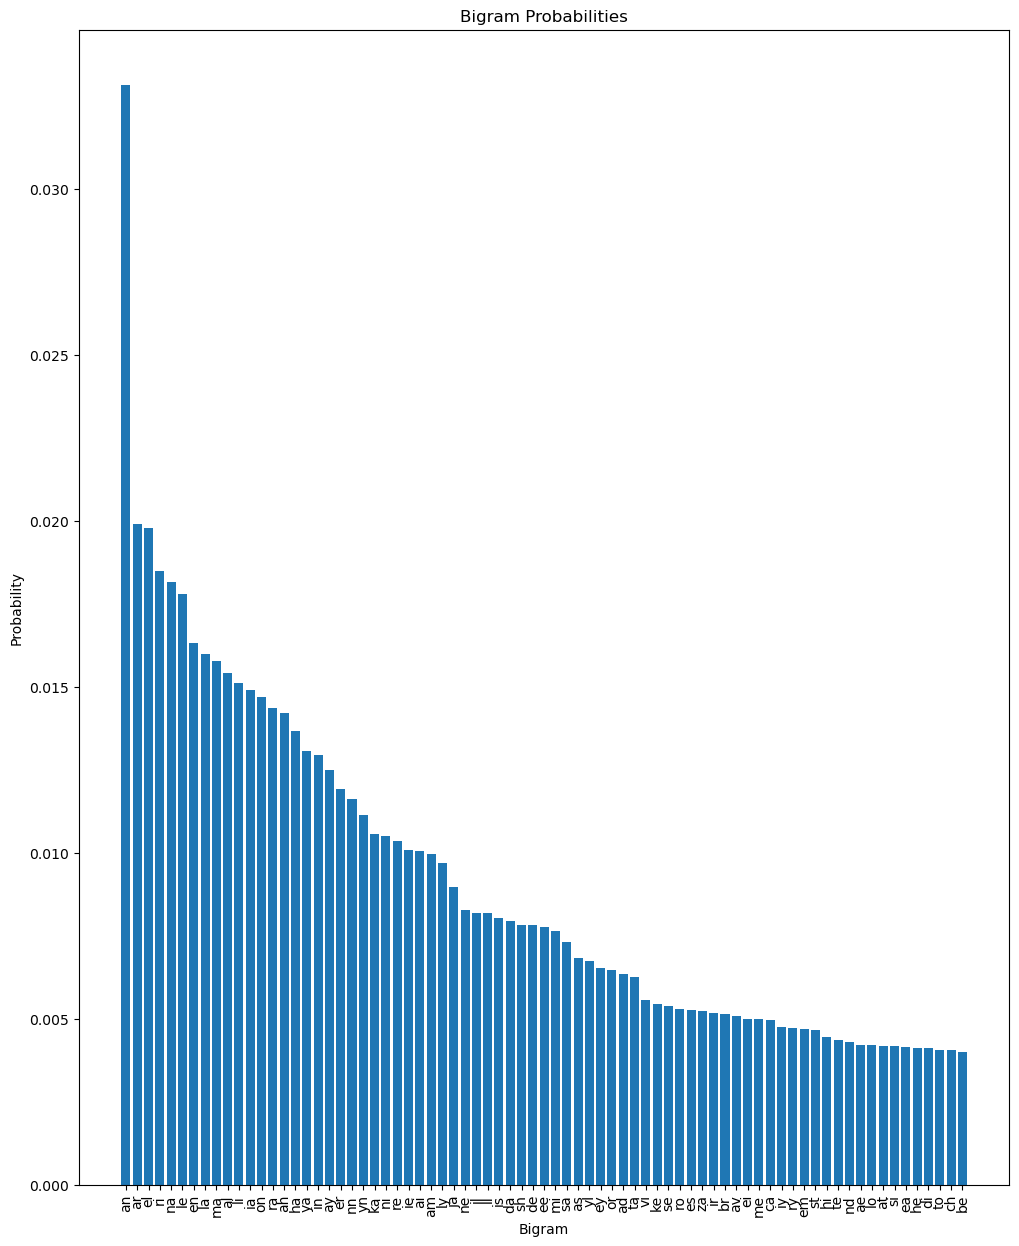

In [17]:
import matplotlib.pyplot as plt

df_n = df_n.head(75)
fig, ax = plt.subplots(figsize=(12,15))
ax.bar(df_n.index, df_n['Probability (P)'])
ax.set_xlabel('Bigram')
ax.set_ylabel('Probability')
ax.set_title('Bigram Probabilities')
plt.xticks(rotation=90)
plt.show()

## Training PyTorch model

In [19]:
import torch
import string
import random

random.seed(42)

with open("names.txt", "r") as f:
    names = f.readlines()

all = string.ascii_lowercase
nn = len(all)

class NameGenerator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NameGenerator, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.fc(output.view(1, -1))
        return output, hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

model = NameGenerator(nn, 128, nn)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

n_epochs = 5000
for epoch in range(n_epochs):
    hidden = model.init_hidden(1)
    loss = 0
    
    name = random.choice(names).lower().strip()
    
    input_tensor = torch.zeros(len(name), nn)
    target_tensor = torch.zeros(len(name), dtype=torch.long)
    for i, char in enumerate(name):
        if char in all:
            input_tensor[i][all.index(char)] = 1
            if i < len(name) - 1 and name[i+1] in all:
                target_tensor[i] = all.index(name[i+1])
    
    for i in range(len(name)-1):
        output, hidden = model(input_tensor[i].unsqueeze(0), hidden)
        loss += criterion(output, target_tensor[i].unsqueeze(0))
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
torch.save(model, 'gen_for_name.pt')

## Generating name using model

In [22]:
import torch

def char_to_tensor(char):
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    tensor = torch.zeros(len(alphabet))
    tensor[alphabet.index(char)] = 1
    return tensor

def generate_name(model):
    start_letter = random.choice(string.ascii_lowercase)

    hidden = torch.zeros(1, 1, model.hidden_size)
    cell = torch.zeros(1, 1, model.hidden_size)
    input_tensor = char_to_tensor(start_letter)
    output_name = start_letter
    max_length = 6
    for i in range(max_length):
        output, (hidden, cell) = model(input_tensor.unsqueeze(0), (hidden, cell))
        output_distribution = output.view(-1).exp()
        top_index = torch.multinomial(output_distribution, 1)[0]
        predicted_char = all[top_index]
        output_name += predicted_char
        if predicted_char == ' ':
            break
        else:
            input_tensor = char_to_tensor(predicted_char)
    return output_name


all = string.ascii_lowercase + " "

model = torch.load('name_generator.pt')

ans = generate_name(model)
print(ans)

deazila


In [203]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
